### Title: Linear Regression with Ridge and Lasso (BenchMark)

Author: Rhys Kilian

Date: 31-10-2018
Linear models, including:

* Linear regression
* LASSO
* Ridge
* Elastic Net

Comparison to the NN models from before.

In [1]:
from numpy.random import seed
seed(1)

import pandas as pd
pd.options.display.max_columns = 999

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Import models from scikit learn module
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

import numpy as np

# 1. Data Preparation

In [2]:
# Read in the data
df = pd.read_csv('../../../0. Data/dataset_add_dummy_seasonal_181021.csv')
df['period'] = pd.to_datetime(df['period'], format='%d/%m/%Y %H:%M')
df.sort_values(by='period', ascending=True, inplace=True)
df.head()

,period,air_temp,price,demand,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_334,lag_335,lag_336,lag_337,lag_338,lag_1006,lag_1007,lag_1008,lag_1009,lag_1010,lag_1679,lag_1680,lag_1681,lag_287,lag_288,lag_289,dummy_Balckout,dummy_HeatWaves,dummy_Winter,dummy_Spring,dummy_Summer
0,2016-05-01 00:30:00,16.65,8.96,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2016-05-01 01:00:00,16.90,5.54,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,2016-05-01 01:30:00,17.00,-0.07,1098.86,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2016-05-01 02:00:00,17.10,-13.21,1032.27,1098.86,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2016-05-01 02:30:00,17.15,-33.19,963.98,1032.27,1098.86,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


We now have to remove the 1681 rows which contain NaN values. Otherwise, we will get errors when trying to create our models.

In [3]:
# Remove NaN values
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True,inplace=True)

## 1.1 Train/Validation/Test Split

If we want a test set of approximately 20% then we need the last two months of data which are March 2017 and April 2017. This gives us a test set of approximately 18.5%. We do the same for the validation set which is January 2017 and February 2017. 

In [4]:
# Create training and test sets
split_point = 12910
df_train_validate = df.iloc[0:split_point,:]
df_test = df.iloc[split_point:,:]

In [5]:
# # Create training and validation sets
# split_point = 10078
# df_train = df_train_validate.iloc[0:split_point,:]
# df_validate = df_train_validate.iloc[split_point:,:]

In [6]:
# Shuffle 
from sklearn.utils import shuffle
df_train_validate = shuffle(df_train_validate)
#df_validate = shuffle(df_validate)
df_test = shuffle(df_test)

## 1.2 Convert Data

In [7]:
# Convert the data
X_train = df_train_validate[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_train = df_train_validate[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_train.shape))
print("Dimensions of X: {}".format(X_train.shape))

Dimensions of y: (12910, 1)
Dimensions of X: (12910, 37)


In [8]:
# # Convert the data
# X_validate = df_validate[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
# y_validate = df_validate[['demand']]

# # Print the dimensions of X and y 
# print("Dimensions of y: {}".format(y_validate.shape))
# print("Dimensions of X: {}".format(X_validate.shape))

In [9]:
# Convert the data
X_test = df_test[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_test = df_test[['demand']]

#X_test = df_test[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289"]]
#y_test = df_test[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_test.shape))
print("Dimensions of X: {}".format(X_test.shape))

Dimensions of y: (2909, 1)
Dimensions of X: (2909, 37)


## 1.3 Data Transformation

In [10]:
# We now create a list of numerical variables which will later be transformed
categorical = ['dummy_Balckout', 'dummy_HeatWaves', 'dummy_Winter', 'dummy_Spring', 'dummy_Summer']
exclude = categorical
numerical=[x for x in list(X_train.columns) if x not in exclude]

In [11]:
# Create numerical and categorical subsets of the data
X_train_numerical=X_train[numerical]
#X_validate_numerical=X_validate[numerical]
X_test_numerical=X_test[numerical]

X_train_categorical=X_train[categorical]
#X_validate_categorical=X_validate[categorical]
X_test_categorical=X_test[categorical]

In [12]:
# Use StandardScaler to transform numerical data
sc = StandardScaler().fit(X_train_numerical)
X_train_numerical_sc = sc.transform(X_train_numerical)
#X_validate_numerical_sc = sc.transform(X_validate_numerical)
X_test_numerical_sc = sc.transform(X_test_numerical)

# Add others here later

In [13]:
# Get the index from the previous numerical df
train_index = X_train_numerical.index
#validate_index = X_validate_numerical.index
test_index = X_test_numerical.index

# Create dataframe
X_train_numerical_sc = pd.DataFrame(X_train_numerical_sc, columns=numerical, index=train_index)
#X_validate_numerical_sc = pd.DataFrame(X_validate_numerical_sc, columns=numerical, index=validate_index)
X_test_numerical_sc = pd.DataFrame(X_test_numerical_sc, columns=numerical, index=test_index)

# Combine the data again to form the complete data set
X_train = pd.concat([X_train_numerical_sc, X_train_categorical], axis=1)
#X_validate = pd.concat([X_validate_numerical_sc, X_validate_categorical], axis=1)
X_test = pd.concat([X_test_numerical_sc, X_test_categorical], axis=1)

In [14]:
# Convert to arrays for modelling
X_train = X_train.values
#X_validate = X_validate.values
X_test = X_test.values

y_train = y_train.values
#y_validate = y_validate.values
y_test = y_test.values

# 2. Modelling

In [15]:
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def mae_cv_train(model):
    mae= -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

def mae_cv_test(model):
    mae= -cross_val_score(model, X_test, y_test, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

def mape_no_cv(model, X, y):
    y_pred = model.predict(X)
    mape = np.abs((y-y_pred))/np.abs(y) # Check this definition
    return np.mean(mape)
    
def mae_no_cv(model, X, y):
    y_pred = model.predict(X)
    return mean_absolute_error(y, y_pred) # Check the order of the inputs here

## 2.1 Linear Regression

In [16]:
# Fit the linear regression
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
# # Find the validation score
# print("Linear Regression MAPE on Validation set :", mape_no_cv(linear, X_validate, y_validate))
# print("Linear Regression MAE on Validation set :", mae_no_cv(linear, X_validate, y_validate))

## 2.2 LASSO

In [18]:
# Find from default hyperparameters 
lasso = LassoCV(cv=10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.3026300223751462


In [19]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 5)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 0.3026300223751462
Best alpha : 0.1815780134250877


In [20]:
# # Find the validation score
# print("Lasso MAPE on Validation set :", mape_no_cv(lasso, X_validate, y_validate))
# print("Lasso MAE on Validation set :", mae_no_cv(lasso, X_validate, y_validate))

Lasso picked 26 features and eliminated the other 11 features


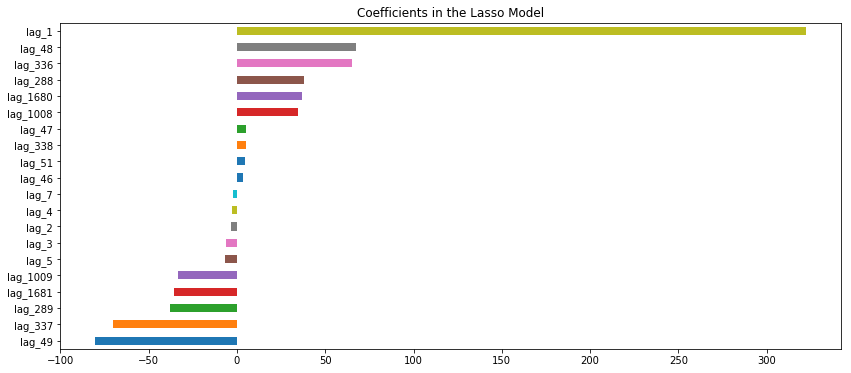

In [37]:
# Plot important coefficients
fig, ax = plt.subplots(figsize=(14,6))
coefs = pd.Series(lasso.coef_, index = df_train_validate.columns[[1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,27,29,30,31,32,33,34,35,36, 37, 38]]) # Check this
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()
fig.savefig('lasso_co.png', bbox_inches='tight')

In [22]:
lasso.coef_.shape

(37,)

## 2.3 Ridge

In [23]:
# Find from default hyperparameters 
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 1.0


In [24]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], cv = 5)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 1.0
Best alpha : 1.15


In [25]:
# # Find the validation score
# print("Ridge MAPE on Validation set :", mape_no_cv(ridge, X_validate, y_validate))
# print("Rige MAE on Validation set :", mae_no_cv(ridge, X_validate, y_validate))

Ridge picked 37 features and eliminated the other 0 features


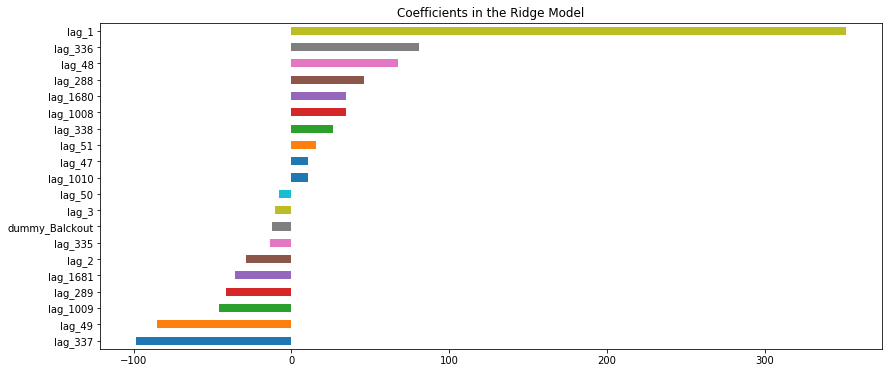

In [38]:
# Plot important coefficients
fig, ax = plt.subplots(figsize=(14,6))
coefs = pd.Series(np.squeeze(ridge.coef_), index = df_train_validate.columns[[1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,27,29,30,31,32,33,34,35,36, 37, 38]]) # Check this
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()
fig.savefig('ridge_co.png', bbox_inches='tight')

## 2.4 Elastic Net

In [27]:
%%time
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )


Best l1_ratio : 1.0
Best alpha : 0.03
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1.0
Best alpha : 0.03
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.03
Best l1_ratio : 1.0
Best alpha : 0.034499999999999996
CPU times: user 28.2 s, sys: 286 ms, total: 28.4 s
Wall time: 7.11 s


In [28]:
# # Find the validation score
# print("Elastic Net MAPE on Validation set :", mape_no_cv(elasticNet, X_validate, y_validate))
# print("Elastic Net MAE on Validation set :", mae_no_cv(elasticNet, X_validate, y_validate))

Elastic Net picked 34 features and eliminated the other 3 features


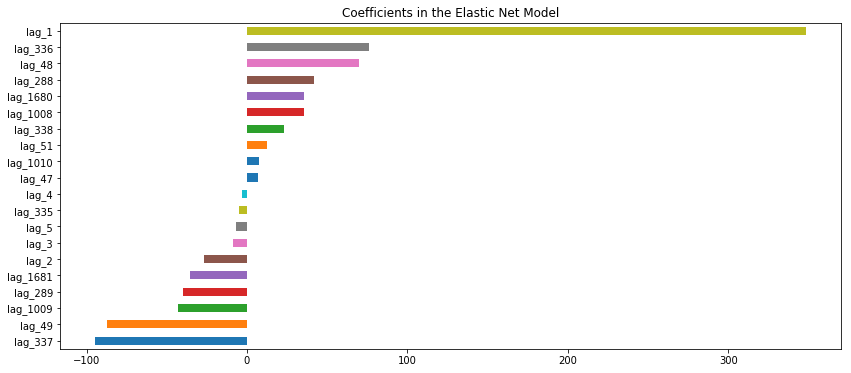

In [39]:
# Plot important coefficients
fig, ax = plt.subplots(figsize=(14,6))
coefs = pd.Series(np.squeeze(elasticNet.coef_), index = df_train_validate.columns[[1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,27,29,30,31,32,33,34,35,36, 37, 38]]) # Check this
print("Elastic Net picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")
plt.show()
fig.savefig('en_co.png', bbox_inches='tight')

# 3. Model Evaluation
Using the test data

In [30]:
# Find the validation score
print("Ridge MAPE on Test set :", mape_no_cv(ridge, X_test, y_test))
print("Rige MAE on Test set :", mae_no_cv(ridge, X_test, y_test))

Ridge MAPE on Test set : 0.015361230002436022
Rige MAE on Test set : 19.52592980391452


In [31]:
# Calculate the predictions 
predictions_ridge = np.squeeze(ridge.predict(X_train))

# Calculate the residuals
residuals_ridge = np.squeeze(y_train) - predictions_ridge

# Create dataframe
d = {'y_train': np.squeeze(y_train), 'predictions': predictions_ridge, 'residuals_ridge': residuals_ridge}
df_residuals_ridge = pd.DataFrame(data=d, index=train_index)

# Left join the period
df_residuals_ridge['period'] = df_train_validate['period']

df_residuals_ridge.shape

# Write to a csv file
df_residuals_ridge.to_csv('residuals_ridge_train_181028.csv', index_label='train_index')

In [32]:
# Calculate the predictions 
predictions_ridge = np.squeeze(ridge.predict(X_test))

# Calculate the residuals
residuals_ridge = np.squeeze(y_test) - predictions_ridge

# Create dataframe
d = {'y_test': np.squeeze(y_test), 'predictions': predictions_ridge, 'residuals_ridge': residuals_ridge}
df_residuals_ridge = pd.DataFrame(data=d, index=test_index)

# Left join the period
df_residuals_ridge['period'] = df_test['period']

df_residuals_ridge.shape

# Write to a csv file
df_residuals_ridge.to_csv('residuals_ridge_test_181028.csv', index_label='test_index')